In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split

2024-07-11 03:36:43.627308: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-11 03:36:43.636455: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-11 03:36:43.647914: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-11 03:36:43.647937: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-11 03:36:43.656013: I tensorflow/core/platform/cpu_feature_gua

Loaded images and masks shapes: (174, 1024, 2048, 3) (174, 1024, 2048, 3)


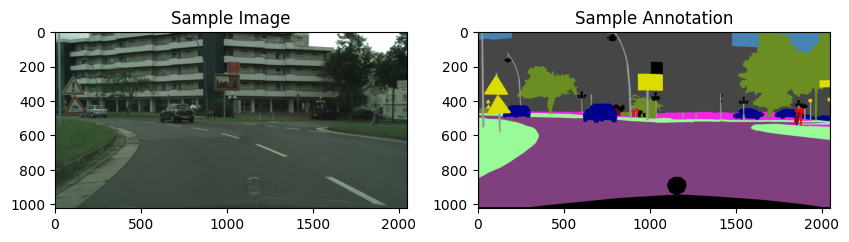

In [2]:
data_dir = '/home/maith/Desktop/Cityscapes'
image_folder = os.path.join(data_dir, 'leftImg8bit_trainvaltest/train')
annotation_folder = os.path.join(data_dir, 'gtFine_trainvaltest/train')

# Function to load images and masks
def load_images_and_masks(city='aachen'):
    images = []
    masks = []
    city_image_path = os.path.join(image_folder, city)
    city_annotation_path = os.path.join(annotation_folder, city)
    image_files = sorted([os.path.join(city_image_path, f) for f in os.listdir(city_image_path) if f.endswith('_leftImg8bit.png')])
    mask_files = sorted([os.path.join(city_annotation_path, f) for f in os.listdir(city_annotation_path) if f.endswith('_gtFine_color.png')])

    for img_path, mask_path in zip(image_files, mask_files):
        img = img_to_array(load_img(img_path))
        mask = img_to_array(load_img(mask_path))
        images.append(img)
        masks.append(mask)

    return np.array(images), np.array(masks)

# Load a sample of images and masks
sample_images, sample_masks = load_images_and_masks()
print("Loaded images and masks shapes:", sample_images.shape, sample_masks.shape)

# Display the first image and mask
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(sample_images[0].astype('uint8'))
plt.title('Sample Image')
plt.subplot(1, 2, 2)
plt.imshow(sample_masks[0].astype('uint8'))
plt.title('Sample Annotation')
plt.show()

In [3]:
def refined_unet(input_shape=(256, 256, 3), num_classes=3):
    inputs = Input(input_shape)

    # Contracting Path
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = BatchNormalization()(c1)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = BatchNormalization()(c2)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = BatchNormalization()(c3)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = BatchNormalization()(c4)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)

    # Bottleneck
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)

    # Expansive Path
    u6 = Conv2DTranspose(512, (3, 3), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(c6)

    u7 = Conv2DTranspose(256, (3, 3), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(c7)

    u8 = Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(c8)

    u9 = Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(c9)

    outputs = Conv2D(num_classes, (1, 1), activation='softmax')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    return model

model = refined_unet()
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

2024-07-11 03:36:59.925381: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-11 03:36:59.941370: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-11 03:36:59.941501: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 256, 256,  │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256, 256,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │     36,928 │ dropout[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        512 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128, 128,  │          0 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │    147,584 │ dropout_1[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │      1,024 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 64, 64,    │          0 │ batch_normalizat… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │    590,080 │ dropout_2[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 32,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │  1,180,160 │ max_pooling2d_2[

 Total params: 34,517,315 (131.67 MB)

 Trainable params: 34,515,395 (131.67 MB)

 Non-trainable params: 1,920 (7.50 KB)

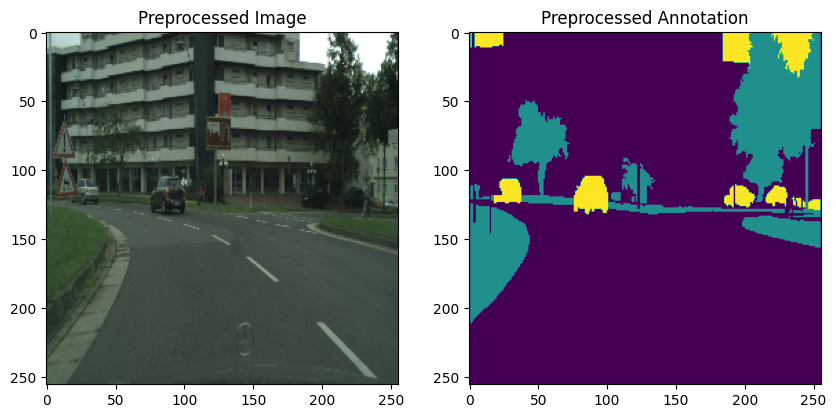

In [4]:
def preprocess_data(images, masks, target_size=(256, 256)):
    """Resize images and masks to target size and normalize images."""
    images_resized = np.array([tf.image.resize(img, target_size).numpy() for img in images])
    masks_resized = np.array([tf.image.resize(mask, target_size, method=tf.image.ResizeMethod.NEAREST_NEIGHBOR).numpy() for mask in masks])
    
    images_normalized = images_resized / 255.0
    masks_converted = np.argmax(masks_resized, axis=-1)

    return images_normalized, masks_converted

images_preprocessed, masks_preprocessed = preprocess_data(sample_images, sample_masks)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(images_preprocessed[0])
plt.title('Preprocessed Image')
plt.subplot(1, 2, 2)
plt.imshow(masks_preprocessed[0])
plt.title('Preprocessed Annotation')
plt.show()

In [5]:
train_images, val_images, train_masks, val_masks = train_test_split(images_preprocessed, masks_preprocessed, test_size=0.2, random_state=42)

In [6]:
def image_mask_generator(images, masks, batch_size):
    size = len(images)
    indices = np.arange(size)
    while True:
        np.random.shuffle(indices)
        for start in range(0, size, batch_size):
            end = min(start + batch_size, size)
            batch_indices = indices[start:end]
            yield images[batch_indices], masks[batch_indices]

Epoch 1/50


I0000 00:00:1720661825.708669  265127 service.cc:145] XLA service 0x7efc7c029780 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1720661825.708699  265127 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 Laptop GPU, Compute Capability 8.9
2024-07-11 03:37:05.846175: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
W0000 00:00:1720661826.027374  265127 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
2024-07-11 03:37:06.238926: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8902
2024-07-11 03:37:13.113756: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 17.26GiB with freed_by_count=0. The caller indicates 

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step - accuracy: 0.5190 - loss: 1.3784

W0000 00:00:1720661885.950770  265137 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


8/8 ━━━━━━━━━━━━━━━━━━━━ 64s 492ms/step - accuracy: 0.5261 - loss: 1.3940 - val_accuracy: 0.7879 - val_loss: 1.0776
Epoch 2/50


W0000 00:00:1720661886.613469  265127 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step - accuracy: 0.5038 - loss: 0.9609

W0000 00:00:1720661930.150589  265122 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


8/8 ━━━━━━━━━━━━━━━━━━━━ 46s 720ms/step - accuracy: 0.5170 - loss: 0.9492 - val_accuracy: 0.7411 - val_loss: 0.9350
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 396ms/step - accuracy: 0.7393 - loss: 0.5810 - val_accuracy: 0.5745 - val_loss: 0.9675
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 410ms/step - accuracy: 0.7857 - loss: 0.5077 - val_accuracy: 0.7566 - val_loss: 0.7835
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 396ms/step - accuracy: 0.8423 - loss: 0.4264 - val_accuracy: 0.8102 - val_loss: 0.7034
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 398ms/step - accuracy: 0.8510 - loss: 0.3844 - val_accuracy: 0.7375 - val_loss: 1.0136
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 410ms/step - accuracy: 0.8637 - loss: 0.3638 - val_accuracy: 0.7592 - val_loss: 0.9805
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 396ms/step - accuracy: 0.8531 - loss: 0.3786 - val_accuracy: 0.7951 - val_loss: 0.7565
Epoch 9/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 397ms/step - accuracy: 0.8741 - loss: 0.3279 - val_accuracy: 0.7481 - val_loss: 1.1579
Ep

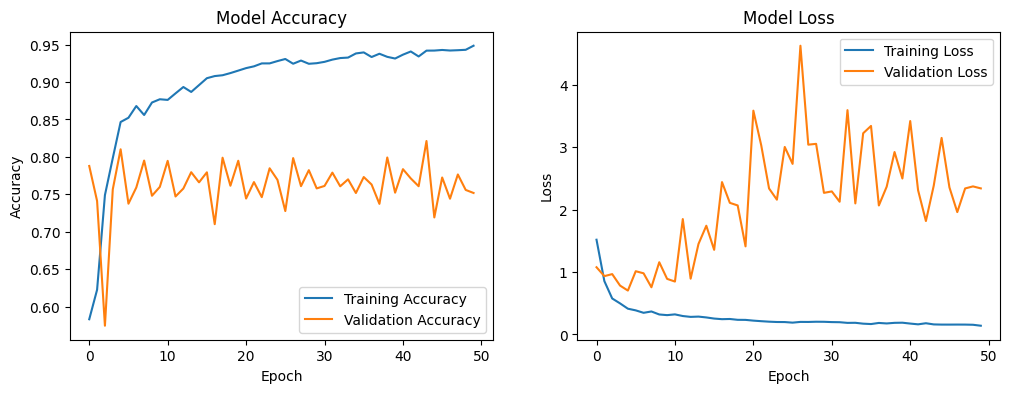

In [7]:
batch_size = 16
epochs = 50

train_gen = image_mask_generator(train_images, train_masks, batch_size)
val_gen = image_mask_generator(val_images, val_masks, batch_size)

history = model.fit(
    train_gen,
    steps_per_epoch=len(train_images) // batch_size,
    epochs=epochs,
    validation_data=val_gen,
    validation_steps=len(val_images) // batch_size
)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [8]:
batch_size = 16
# Load test images and masks
test_images, test_masks = load_images_and_masks(city='aachen')

# Preprocess the test data
test_images_preprocessed, test_masks_preprocessed = preprocess_data(test_images, test_masks)

# Define test generator
test_gen = image_mask_generator(test_images_preprocessed, test_masks_preprocessed, batch_size)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_gen, steps=len(test_images_preprocessed) // batch_size)
print(f"Test Accuracy: {test_accuracy:.2%}, Test Loss: {test_loss}")

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 0.7492 - loss: 2.3434
Test Accuracy: 74.12%, Test Loss: 2.4186198711395264


In [9]:
model.save('cityscapes_segmentation_model.keras')

# Save the model in TensorFlow's SavedModel format
model.export('cityscapes_segmentation_model')
import tensorflow as tf

# Load the saved model
saved_model_dir = 'cityscapes_segmentation_model'
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)

# Convert the model to TensorFlow Lite format
tflite_model = converter.convert()

# Save the TensorFlow Lite model to a .tflite file
tflite_model_path = 'cityscapes_segmentation_model.tflite'
with open(tflite_model_path, 'wb') as f:
    f.write(tflite_model)

    import tensorflow as tf

# Load the saved model
saved_model_dir = 'cityscapes_segmentation_model'
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)

# Convert the model to TensorFlow Lite format
tflite_model = converter.convert()

# Save the TensorFlow Lite model to a .tflite file
tflite_model_path = 'cityscapes_segmentation_model.tflite'
with open(tflite_model_path, 'wb') as f:
    f.write(tflite_model)

print(f"Model successfully converted and saved at {tflite_model_path}")

INFO:tensorflow:Assets written to: cityscapes_segmentation_model/assets


INFO:tensorflow:Assets written to: cityscapes_segmentation_model/assets


Saved artifact at 'cityscapes_segmentation_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None)
Captures:
  139631829282560: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139631829283616: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139631829282912: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139631829283968: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139631829283440: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139631829282736: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139631829283792: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139631829285200: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139631829285024: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139631829285728: TensorSpec(shape=(), dtype=tf.resource, name

W0000 00:00:1720662106.591664  264208 tf_tfl_flatbuffer_helpers.cc:390] Ignored output_format.
W0000 00:00:1720662106.592146  264208 tf_tfl_flatbuffer_helpers.cc:393] Ignored drop_control_dependency.
2024-07-11 03:41:46.595529: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: cityscapes_segmentation_model
2024-07-11 03:41:46.597714: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-07-11 03:41:46.597728: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: cityscapes_segmentation_model
2024-07-11 03:41:46.620683: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:388] MLIR V1 optimization pass is not enabled
2024-07-11 03:41:46.623304: I tensorflow/cc/saved_model/loader.cc:234] Restoring SavedModel bundle.
2024-07-11 03:41:46.811107: I tensorflow/cc/saved_model/loader.cc:218] Running initialization op on SavedModel bundle at path: cityscapes_segmentation_model
2024-07-11 03:41:46.834506

Model successfully converted and saved at cityscapes_segmentation_model.tflite


In [10]:
import tensorflow as tf

# Load the pre-trained model
model = tf.keras.models.load_model('cityscapes_segmentation_model.keras')

# Display model summary to confirm successful loading
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 256, 256,  │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256, 256,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │     36,928 │ dropout[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        512 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128, 128,  │          0 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │    147,584 │ dropout_1[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │      1,024 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 64, 64,    │          0 │ batch_normalizat… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │    590,080 │ dropout_2[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 32,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │  1,180,160 │ max_pooling2d_2[

 Total params: 103,548,107 (395.00 MB)

 Trainable params: 34,515,395 (131.67 MB)

 Non-trainable params: 1,920 (7.50 KB)

 Optimizer params: 69,030,792 (263.33 MB)

: 

In [11]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Assuming you have test images and masks
data_dir = '/home/maith/Desktop/Cityscapes'
test_image_folder = os.path.join(data_dir, 'leftImg8bit_trainvaltest/test')
test_annotation_folder = os.path.join(data_dir, 'gtFine_trainvaltest/test')

# Function to load test images and masks
def load_test_images_and_masks(city='berlin'):
    images = []
    masks = []
    city_image_path = os.path.join(test_image_folder, city)
    city_annotation_path = os.path.join(test_annotation_folder, city)
    image_files = sorted([os.path.join(city_image_path, f) for f in os.listdir(city_image_path) if f.endswith('_leftImg8bit.png')])
    mask_files = sorted([os.path.join(city_annotation_path, f) for f in os.listdir(city_annotation_path) if f.endswith('_gtFine_color.png')])

    for img_path, mask_path in zip(image_files, mask_files):
        img = img_to_array(load_img(img_path))
        mask = img_to_array(load_img(mask_path))
        images.append(img)
        masks.append(mask)

    return np.array(images), np.array(masks)

# Load a sample of test images and masks
test_sample_images, test_sample_masks = load_test_images_and_masks()
print("Loaded test images and masks shapes:", test_sample_images.shape, test_sample_masks.shape)

# Preprocess the test data
def preprocess_data(images, masks, target_size=(256, 256)):
    """Resize images and masks to target size and normalize images."""
    images_resized = np.array([tf.image.resize(img, target_size).numpy() for img in images])
    masks_resized = np.array([tf.image.resize(mask, target_size, method=tf.image.ResizeMethod.NEAREST_NEIGHBOR).numpy() for mask in masks])
    
    # Normalize the images properly to the range [0, 1]
    images_normalized = images_resized / 255.0

    # Convert masks to a single channel with integer labels
    masks_converted = np.argmax(masks_resized, axis=-1)  # This assumes your masks are initially one-hot encoded

    return images_normalized, masks_converted

test_images_preprocessed, test_masks_preprocessed = preprocess_data(test_sample_images, test_sample_masks)

# Display the first preprocessed test image and mask
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(test_images_preprocessed[0])
plt.title('Preprocessed Test Image')
plt.subplot(1, 2, 2)
plt.imshow(test_masks_preprocessed[0])
plt.title('Preprocessed Test Annotation')
plt.show()

# Define a simple data generator
def image_mask_generator(images, masks, batch_size):
    size = len(images)
    indices = np.arange(size)
    while True:
        np.random.shuffle(indices)
        for start in range(0, size, batch_size):
            end = min(start + batch_size, size)
            batch_indices = indices[start:end]
            yield images[batch_indices], masks[batch_indices]

# Create a test generator
batch_size = 2  # Reduced batch size to handle memory issues
test_gen = image_mask_generator(test_images_preprocessed, test_masks_preprocessed, batch_size)

# Load the trained model
model = tf.keras.models.load_model('cityscapes_segmentation_model.h5')  # Replace with your model path

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_gen, steps=len(test_images_preprocessed) // batch_size)
print(f"Test Accuracy: {test_accuracy:.2%}, Test Loss: {test_loss}")